<a href="https://colab.research.google.com/github/gprasads/Crowd-image-classification/blob/master/mlhw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#importing libraries
import numpy as np
import matplotlib.pyplot as mpl
import pandas as pd
import pickle

train_labels = pd.read_csv('/content/drive/My Drive/ml_hw3/Train_Labels.csv')
test_labels= pd.read_csv('/content/drive/My Drive/ml_hw3/Val_Labels.csv')

with open("/content/drive/My Drive/ml_hw3/Train_Features.pkl", 'rb') as file:
  train_pickle = pickle.load(file, encoding="latin1")
  train_data = pd.DataFrame(train_pickle).T  
  
with open("/content/drive/My Drive/ml_hw3/Val_Features.pkl", 'rb') as file:
  test_pickle = pickle.load(file, encoding="latin1")
  test_data = pd.DataFrame(test_pickle).T  

with open("/content/drive/My Drive/ml_hw3/Test_Features.pkl", 'rb') as file:
  sub_pickle = pickle.load(file, encoding="latin1")
  sub_data = pd.DataFrame(sub_pickle).T  



In [0]:
train_data.index.name = 'rowId'
train_data.reset_index(inplace=True)
test_data.index.name = 'rowId'
test_data.reset_index(inplace=True)
sub_data.index.name = 'rowId'
sub_data.reset_index(inplace=True)

In [0]:
train_full_data=pd.merge(train_data, train_labels, left_on='rowId', right_on='Id',how='inner')
test_full_data=pd.merge(test_data, test_labels, left_on='rowId', right_on='Id',how='inner')
sub_full_data=pd.merge(sub_data, train_labels, left_on='rowId', right_on='Id',how='left')

In [0]:
x_train=train_full_data[train_full_data.columns.difference(['Id', 'rowId','Category'])]
x_test=test_full_data[test_full_data.columns.difference(['Id', 'rowId','Category'])]
x_sub=sub_full_data[sub_full_data.columns.difference(['Id', 'rowId','Category'])]
y_train=train_full_data[['Category']]
y_test=test_full_data[['Category']]

In [0]:
from sklearn.preprocessing import OneHotEncoder 

onehotencoder = OneHotEncoder(categorical_features = [0]) 
y_train_encoded = onehotencoder.fit_transform(y_train).toarray() 


In [0]:
onehotencoder = OneHotEncoder(categorical_features = [0]) 
y_test_encoded = onehotencoder.fit_transform(y_test).toarray() 

In [0]:
import numpy as np
import math 
import secrets

def pseudo_softmax(x,last_class):
  sum=np.sum(np.exp(x))
  
  if last_class:
    return (1 /(1+sum))
  else:
    out=[]
    for i in x:
      out.append(i/(1+sum))
    return out
  
def batchify(n,m):
    numbers=list(range(n))
    batches=[]
    while len(numbers)>0:
        c_list=[]
        for i in range(m):
            c=secrets.choice(numbers)
            c_list.append(c)
            numbers.remove(c)
            if len(numbers) == 0:
                break
        if len(c_list) == m:
            batches.append(c_list)
        elif len(c_list)<len(batches):
            for i in range(len(c_list)):
                batches[i].append(c_list[i])
        else:
            batches.append(c_list)
    return batches
  
def der_function(X,Y,theta_transpose,values,k):
  (rows, columns) = X.shape
  X1 = np.ones(columns, dtype=int)
  Xbar = np.vstack([X, X1])    
  der=0
  for i in values:
    Xj = Xbar[..., i].ravel()
    epow = theta_transpose.dot(Xj)
    sigmoid=pseudo_softmax(epow,False)
    Xj=np.asarray(Xj)[np.newaxis]
    diff=np.subtract(Y[i][0:k],sigmoid)
    diff=np.asarray(diff)[np.newaxis]
    diff=diff.T
    der=der+diff.dot(Xj)
  return 0-(1/len(values))*der

def l_theta_function(X,Y,theta_transpose):

    (rows, columns) = X.shape
    Y=np.asarray(Y)
    X1 = np.ones(columns, dtype=int)
    Xbar = np.vstack([X, X1])
    theta_transpose=np.asarray(theta_transpose, dtype=np.float32)
    sumX=0
    for i in range(columns):
        Xi = Xbar[..., i].ravel()
        theta_transpose = np.asarray(theta_transpose)
        epow = theta_transpose.dot(Xi)
        sigmoid=pseudo_softmax(epow,False)
        sum=0
        for k in range(3):
          sum= sum+ sigmoid[k]-(np.log(1+np.sum(np.exp(epow))))
        sumX=sumX+sum
    op =0-(sum/columns)
    return op
    
def stocastic_gradient_function(X,Y,m,eta0,eta1,max_epoch,delta,K_size,Y_un):
    l_theta_old=0
    plot=[]
    accuracy=[]
    (rows,columns) = X.shape
    for i in range(20):
      theta_transpose=np.ones([3,rows+1],dtype=float)
      batches=batchify(columns,m)
      eta=eta0/(eta1+i)      
      for k in range(len(batches)):
        theta_transpose= np.subtract(theta_transpose,eta*der_function(X,Y,theta_transpose,batches[k],K_size-1))
      accuracy.append((i,(accuracy_predictions_for_epoch(theta_transpose,Y_un,columns,X))))
      l_theta_new=l_theta_function(X,Y,theta_transpose)
      if l_theta_old==0:
        l_theta_old=l_theta_new
        plot.append((i,l_theta_new))
      elif l_theta_new>((1-delta)*l_theta_old):
          plot.append((i,l_theta_new))
          return (accuracy,plot,theta_transpose)
      else:
          plot.append((i,l_theta_new))
          l_theta_old=l_theta_new
            
    return (accuracy,plot,theta_transpose)

def accuracy_predictions_for_epoch(Theta,Y_un,columns,X):
    O=[]
    X1 = np.ones(columns, dtype=int)
    Xbar = np.vstack([X, X1])
    for i in range(columns):
        Xi = Xbar[..., i].ravel()
        Xi=np.asarray(Xi)[np.newaxis]
        Xi=np.transpose(Xi)
        epow = Theta.dot(Xi)
        sigmoid=[]
        for s in pseudo_softmax(epow,False):
          sigmoid.append(s)
        sigmoid.append(pseudo_softmax(epow,True))
        O.append(sigmoid)
    Out1=pd.DataFrame(data=O,columns=['1','2','3','4'],dtype=float)
    Category=pd.DataFrame(data=Out1.idxmax(axis=1),columns=['Category'])
    Arr1=Y_un.values.astype(np.float).flatten()
    Arr2=Category['Category'].values.astype(np.float).flatten()
    return np.equal(Arr1,Arr2).tolist().count(True)/len(Y_un)
    
  
def logistic_regression_function(X_test,X,Y,m,eta0,eta1,ma_epoch,delta,K_size,Y_un):
    (rows, columns) = X_test.shape
    X1 = np.ones(columns, dtype=int)
    Xbar = np.vstack([X_test, X1])
    accuracy,plot,Theta =stocastic_gradient_function(X,Y,m,eta0,eta1,ma_epoch,delta,K_size,Y_un)
    O=[]
    for i in range(columns):
        Xi = Xbar[..., i].ravel()
        Xi=np.asarray(Xi)[np.newaxis]
        Xi=np.transpose(Xi)
        epow = Theta.dot(Xi)
        sigmoid=[]
        for s in pseudo_softmax(epow,False):
          sigmoid.append(s)
        sigmoid.append(pseudo_softmax(epow,True))
        O.append(sigmoid)
    return (O,plot,accuracy)

In [0]:
x=np.transpose(x_train.values)/np.linalg.norm(np.transpose(x_train.values),2)
xt=np.transpose(x_test.values)/np.linalg.norm(np.transpose(x_test.values),2)
xs=np.transpose(x_sub.values)/np.linalg.norm(np.transpose(x_sub.values),2)
accuracy_random_temp,plot_random_temp,Theta_random_temp=stocastic_gradient_function(x,y_train_encoded,16,0.1,1,1000,0.00001,4,y_train)

In [0]:
Theta_random_temp

In [0]:
x=np.transpose(x_train.values)/np.linalg.norm(np.transpose(x_train.values),2)
xt=np.transpose(x_test.values)/np.linalg.norm(np.transpose(x_test.values),2)
xs=np.transpose(x_sub.values)/np.linalg.norm(np.transpose(x_sub.values),2)
Out,plot_standard,accuracy_std=logistic_regression_function(xs,x,y_train_encoded,16,0.1,1,1000,0.00001,4,y_train)
Out_eta,plot_eta,accuracy_eta=logistic_regression_function(xs,x,y_train_encoded,16,0.1,10,1000,0.00001,4,y_train)
Out_t,plot_t,accuracytem=logistic_regression_function(xt,xt,y_test_encoded,16,0.1,1,1000,0.00001,4,y_test)
Out_at,plot_at,accuracy_at=logistic_regression_function(xt,xt,y_test_encoded,16,0.1,1,1000,0.00001,4,y_test)
Out_sa,plot_sa,accuracy_sa=logistic_regression_function(x,x,y_train_encoded,16,0.1,1,1000,0.00001,4,y_train)

Text(0, 0.5, 'L(theta)')

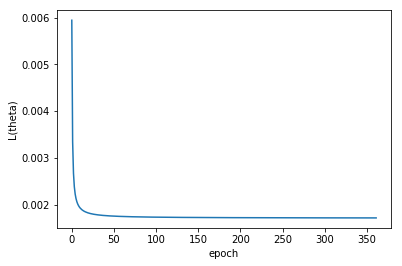

In [0]:
import matplotlib.pyplot as mpl
Out1=pd.DataFrame(data=Out,columns=['1','2','3','4'],dtype=float)
Category=pd.DataFrame(data=Out1.idxmax(axis=1),columns=['Category'])

plot_s=plot_standard
plotter=pd.DataFrame(plot_s, columns=['epoch','l_theta'])

mpl.plot(plotter['epoch'],plotter['l_theta'])
mpl.xlabel('epoch') 
mpl.ylabel('L(theta)')

**OBSERVED VALUES**

epoch = 361

L(theta):0.001717770475179635

Text(0, 0.5, 'L(theta)')

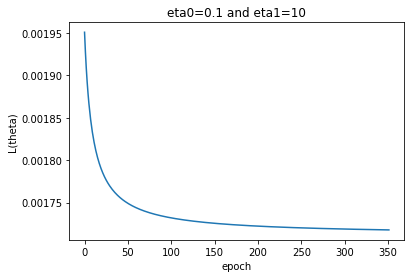

In [0]:
plotter_eta=pd.DataFrame(plot_eta, columns=['epoch','l_theta'])
mpl.plot(plotter_eta['epoch'],plotter_eta['l_theta'])
mpl.title('eta0=0.1 and eta1=10')
mpl.xlabel('epoch') 
mpl.ylabel('L(theta)')

**ETA VALUE**

eta0 = 0.1

eta1 = 10

Epoch at eta 0.1 and 10: 351

L theta =0.0017177875813974856 

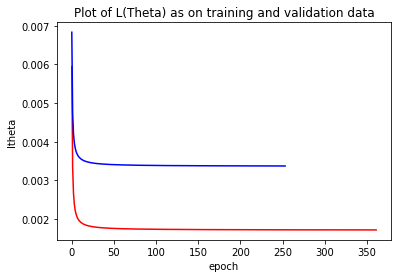

In [0]:
plotter_t=pd.DataFrame(plot_t, columns=['epoch','l_theta'])
mpl.plot(plotter['epoch'], plotter['l_theta'], 'r') 
mpl.plot(plotter_t['epoch'], plotter_t['l_theta'], 'b') 
mpl.title('Plot of L(Theta) as on training and validation data')
mpl.xlabel('epoch')
mpl.ylabel('ltheta')
mpl.show()


In [0]:

atplotter=pd.DataFrame(accuracy_at, columns=['epoch','accuracy'])
saplotter=pd.DataFrame(accuracy_sa, columns=['epoch','accuracy'])
mpl.plot(atplotter['epoch'], atplotter['accuracy'], 'r') 
mpl.plot(saplotter['epoch'], saplotter['accuracy'], 'b') 
mpl.title('Plot of Accuracy vs epoch as on training and validation data')
mpl.xlabel('epoch')
mpl.ylabel('accuracy')
mpl.show()

In [0]:
from sklearn.metrics import confusion_matrix

Out_ct,plot_ct,ac1=logistic_regression_function(xt,x,y_train_encoded,16,0.1,1,1000,0.00001,4,y_train)
Out_ctr,plot_ctr,ac2=logistic_regression_function(x,x,y_train_encoded,16,0.1,1,1000,0.00001,4,y_train)
Out1_ct=pd.DataFrame(data=Out_ct,columns=['1','2','3','4'],dtype=float)
Out1_ctr=pd.DataFrame(data=Out_ctr,columns=['1','2','3','4'],dtype=float)
Category_ct=pd.DataFrame(data=Out1_ct.idxmax(axis=1),columns=['Category'])
Category_ctr=pd.DataFrame(data=Out1_ctr.idxmax(axis=1),columns=['Category'])

results_1 = confusion_matrix(y_test.values.astype(np.float), Category_ct['Category'].values.astype(np.float))
results_2 = confusion_matrix(y_train.values.astype(np.float), Category_ctr['Category'].values.astype(np.float))

print('Confusion matrix For Test Data')
print(results_1)
print('Confusion matrix for Training data')
print(results_2)

In [0]:
Category_ct['Category'].values.tolist()

In [0]:
output_df = pd.DataFrame({'Id': sub_full_data['rowId'], 'Category': Out1.idxmax(axis=1)})

In [0]:
output_df

In [0]:
output_df.to_csv('submission_hw3v1.csv', header=False, index=False)